In [1]:
!pip install fuzzywuzzy

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import spacy
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import re
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
#from distance import distance

<h2> 4.1 Reading data from file</h2>

In [0]:
df= pd.read_csv("./final.csv")
df = df[:100000]

In [7]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
Unnamed: 0              100000 non-null int64
id                      100000 non-null int64
qid1                    100000 non-null int64
qid2                    100000 non-null int64
question1               100000 non-null object
question2               100000 non-null object
is_duplicate            100000 non-null int64
freq_qid1               100000 non-null int64
freq_qid2               100000 non-null int64
q1len                   100000 non-null int64
q2len                   100000 non-null int64
q1_n_words              100000 non-null int64
q2_n_words              100000 non-null int64
word_Common             100000 non-null float64
word_Total              100000 non-null float64
word_share              100000 non-null float64
freq_q1+q2              100000 non-null int64
freq_q1-q2              100000 non-null int64
cwc_min                 100000 non-null float64
cwc_ma

## 4.2 Preprocessing

In [10]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [Unnamed: 0, id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []


In [11]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [Unnamed: 0, id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []


In [0]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
print("Extracting features for train:")
df = extract_features(df)

In [0]:
#df = df[:40000]
# encode questions to unicode
# https://stackoverflow.com/a/6812069
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

[](http://) <h2> 4.3 Random train test split( 70:30) </h2>

In [0]:
y_true = df["is_duplicate"]
train_points,test_points, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [0]:
train_points = train_points.reset_index(drop='true')
test_points = test_points.reset_index(drop='true')

In [0]:
listTrain = train_points["question1"] + train_points["question2"]
listTest = test_points["question1"] + test_points["question2"]

## TFIDF

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
text_vectorizer = TfidfVectorizer()
kbest= SelectKBest(k=1000)
vectorizer = make_pipeline(text_vectorizer, kbest)
X_train_tfidf = vectorizer.fit_transform(listTrain,y_train)
X_test_tfidf = vectorizer.transform(listTest)

In [18]:
print("Number of data points in train data :",X_train_tfidf.shape)
print("Number of data points in test data :",X_test_tfidf.shape)

Number of data points in train data : (70000, 1000)
Number of data points in test data : (30000, 1000)


In [19]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8869093558675201


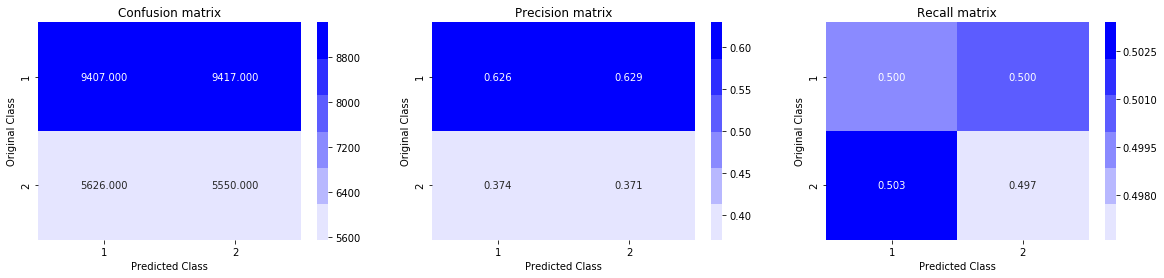

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5386503461320374
For values of alpha =  0.0001 The log loss is: 0.5503459866292768
For values of alpha =  0.001 The log loss is: 0.5733602515758659
For values of alpha =  0.01 The log loss is: 0.5842173273911895
For values of alpha =  0.1 The log loss is: 0.6222679438460069
For values of alpha =  1 The log loss is: 0.6333720108215934
For values of alpha =  10 The log loss is: 0.6345797302852779


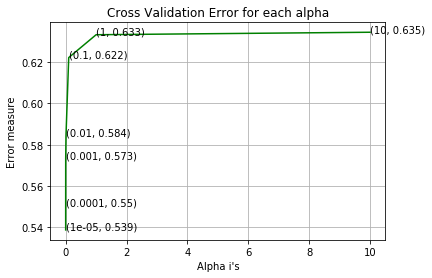

For values of best alpha =  1e-05 The train log loss is: 0.5291731264086454
For values of best alpha =  1e-05 The test log loss is: 0.5386503461320374
Total number of data points : 30000


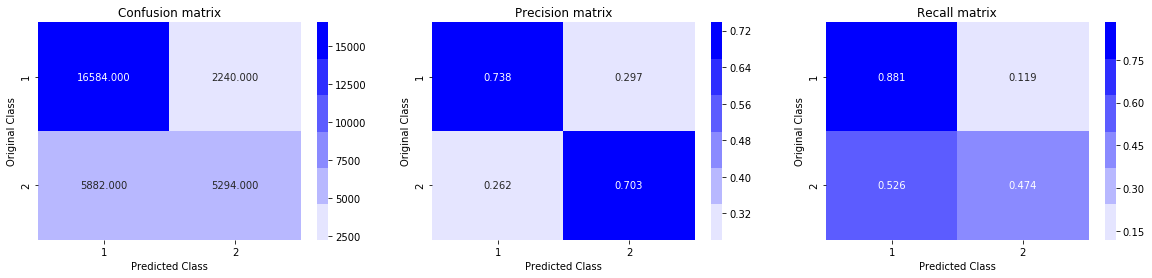

In [23]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5516501026571353
For values of alpha =  0.0001 The log loss is: 0.5770699914244293
For values of alpha =  0.001 The log loss is: 0.6420379217468124
For values of alpha =  0.01 The log loss is: 0.6602902102099693
For values of alpha =  0.1 The log loss is: 0.660290210209969
For values of alpha =  1 The log loss is: 0.6602902102099691
For values of alpha =  10 The log loss is: 0.660290210209969


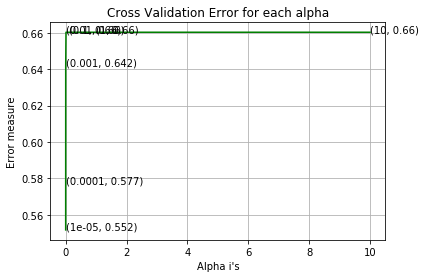

For values of best alpha =  1e-05 The train log loss is: 0.5427194933713337
For values of best alpha =  1e-05 The test log loss is: 0.5516501026571353
Total number of data points : 30000


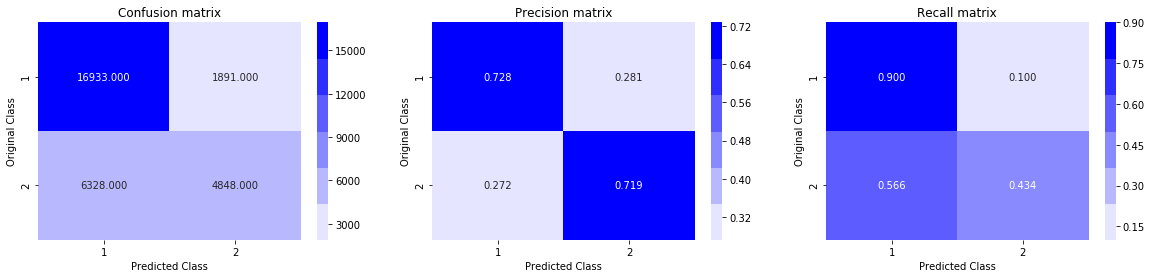

In [24]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## TF-IDF weighted W2V

In [0]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(listTrain)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

### For Train Points

In [34]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(train_points['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
train_points['q1_feats_m'] = list(vecs1)

100%|██████████| 70000/70000 [12:00<00:00, 97.14it/s]


In [35]:
vecs2 = []
for qu2 in tqdm(list(train_points['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
train_points['q2_feats_m'] = list(vecs2)

100%|██████████| 70000/70000 [12:04<00:00, 96.67it/s] 


In [56]:
df1 = train_points.drop(['Unnamed: 0','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)

#creating dataframe of 384 features of q1 and q2
df3_q1 = pd.DataFrame(train_points.q1_feats_m.values.tolist(), index= train_points.index)
df3_q2 = pd.DataFrame(train_points.q2_feats_m.values.tolist(), index= train_points.index)
df3_q1['id']=train_points['id']
df3_q2['id']=train_points['id']
df2  = df3_q1.merge(df3_q2, on='id',how='left')
df_train  = df1.merge(df2, on='id',how='left')
df_train = df_train.drop(['id'],axis = 1)
df_train.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,1,1,47,30,9,5,4.0,14.0,0.285714,2,0,0.999967,0.749981,0.666644,0.399992,0.833319,0.555549,1.0,1.0,3.0,7.5,95,79,74,74,0.343750,134.898796,10.679454,-27.376336,-67.418310,0.248104,14.276361,66.521531,62.652553,-68.245691,116.629425,39.540244,47.482707,-66.801117,...,-41.249760,29.515581,3.416358,-1.224006,-9.719035,-20.522738,51.201651,-6.501781,0.374769,67.006436,-11.530559,3.877284,-53.564972,-40.196219,-5.664244,2.851845,30.548400,-2.632833,-39.033426,1.676972,18.111092,-72.052274,-30.346890,-27.048837,-5.792227,-13.204625,-43.126993,-1.169759,-11.262710,-73.919977,8.921831,-41.872143,48.695303,31.415970,11.432508,11.154264,-5.795942,-4.403995,-40.810074,-14.542787
1,0,1,1,31,31,5,5,4.0,10.0,0.400000,2,0,0.666644,0.666644,0.999950,0.999950,0.799984,0.799984,1.0,1.0,0.0,5.0,97,80,97,97,0.812500,-3.586466,34.349188,-41.860544,-53.122313,-0.229736,35.703899,4.516807,38.660771,13.281556,28.400802,11.936937,-40.773949,1.269317,...,30.822171,-16.513858,-16.209728,83.038949,-57.459604,19.669240,-5.833894,-65.270119,0.431573,39.795779,3.451826,25.885681,-43.506918,-8.135757,-68.153657,-31.958616,-57.147154,53.647186,-23.808873,80.714635,64.215124,-48.478872,-3.680592,55.540714,2.843174,-77.644158,-57.095011,74.475081,64.731919,-54.703351,66.738629,1.227190,55.264199,34.470862,-14.353170,25.906015,66.072036,-39.383743,-118.033014,47.123302
2,1,2,7,77,72,17,16,10.0,31.0,0.322581,9,5,0.499988,0.399992,0.799992,0.727266,0.624996,0.588232,0.0,0.0,1.0,16.5,79,77,61,64,0.246575,45.472202,-46.670001,-110.548251,-104.304195,-121.990976,0.567955,20.010656,64.052941,-13.948131,39.436228,-5.826373,85.267488,-67.135466,...,-9.255384,33.277448,-83.102495,24.449053,-1.143028,-27.537369,95.942933,-74.322810,-69.042052,20.944222,3.553416,45.303764,-54.443689,-20.160220,55.755073,-65.524854,-44.320576,50.073181,30.433591,77.727092,46.288360,-30.407319,-10.057375,33.926955,5.065606,-15.393151,-115.253513,59.299041,-12.824028,-43.313149,85.403918,-28.196767,13.574977,86.146718,5.338395,-16.330977,157.469990,39.691753,1.741295,-15.658196
3,0,1,3,27,45,6,10,1.0,16.0,0.062500,4,2,0.999950,0.499988,0.000000,0.000000,0.333328,0.199998,0.0,0.0,4.0,8.0,59,57,46,59,0.321429,-36.684502,-16.497057,-28.648666,-49.791056,-32.559881,10.552995,-1.237183,0.975885,-7.639395,6.225756,5.259241,28.775160,-11.254059,...,29.173659,34.698686,-38.660875,45.935580,-0.953877,-8.617037,28.284777,15.578406,4.188966,35.074282,13.622373,60.849590,-12.783779,-44.629240,-11.584488,37.215251,-22.816953,35.346216,18.377367,74.099116,62.330874,-34.889161,-32.091110,14.290120,13.252618,-17.963062,-45.495150,-0.849456,-2.232517,-33.451615,30.277311,-1.321549,48.699787,26.761197,11.036939,7.138589,29.838918,-6.425161,15.337393,-42.977120
4,0,1,1,86,86,19,19,18.0,38.0,0.473684,2,0,0.916659,0.916659,0.999986,0.999986,0.947363,0.947363,1.0,1.0,0.0,19.0,99,99,99,99,0.882353,108.473263,-90.475444,-153.205260,-221.276137,25.429316,88.600046,148.311011,62.928786,-96.429422,153.829035,-5.946575,78.993741,-198.574708,...,50.118422,9.388623,-182.352556,91.824130,-69.852397,-111.235757,102.062385,-125.144483,-30.073038,123.377096,16.708209,60.720418,-111.556808,94.529116,166.028820,-52.328907,109.114446,131.888610,113.400236,97.503401,51.749469,-37.025661,-59.007704,-131.882406,-52.909239,-133.092678,-213.689294,162.626553,66.052544,-149.059089,39.495645,-85.753494,141.987425,-2.818966,-138.848002,32.872821,32.273191,-60.271216,-34.876078,15.

### For Test Points

In [44]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(test_points['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
test_points['q1_feats_m'] = list(vecs1)

100%|██████████| 30000/30000 [05:03<00:00, 98.75it/s]


In [45]:
vecs2 = []
for qu2 in tqdm(list(test_points['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
test_points['q2_feats_m'] = list(vecs2)

100%|██████████| 30000/30000 [04:53<00:00, 102.10it/s]


In [57]:
df1 = test_points.drop(['Unnamed: 0','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)

#creating dataframe of 384 features of q1 and q2
df3_q1 = pd.DataFrame(test_points.q1_feats_m.values.tolist(), index= test_points.index)
df3_q2 = pd.DataFrame(test_points.q2_feats_m.values.tolist(), index= test_points.index)
df3_q1['id']=test_points['id']
df3_q2['id']=test_points['id']
df2  = df3_q1.merge(df3_q2, on='id',how='left')
df_test  = df1.merge(df2, on='id',how='left')
df_test = df_test.drop(['id'],axis = 1)
df_test.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,51,54,10,10,9.0,20.0,0.450000,3,1,0.799984,0.799984,0.999980,0.999980,0.899991,0.899991,1.0,1.0,0.0,10.0,91,81,91,88,0.538462,52.535303,-19.269663,-33.174415,-54.404596,-67.838568,-14.042941,-0.980152,3.902655,-4.462158,52.916969,-28.709969,-12.303082,-30.246642,...,50.931302,-30.407326,-66.959035,72.643076,-55.525349,-21.251377,38.528072,-66.835026,-27.089268,32.554437,18.058290,9.336204,-62.135405,37.893861,0.450215,-15.343116,-2.524157,133.234222,75.925941,86.079431,-29.406980,28.024630,-35.470612,-12.652963,28.464194,1.570193,-121.469814,-9.967738,33.321779,-33.439813,91.545915,-24.947035,3.000691,7.709724,-32.458822,-11.538412,14.644781,24.943615,-16.166208,119.155554
1,0,1,1,110,116,17,17,16.0,34.0,0.470588,2,0,0.909083,0.909083,0.999986,0.999986,0.944439,0.944439,1.0,1.0,0.0,18.0,98,94,95,92,0.819820,220.358478,20.700595,-133.265723,-170.954267,-121.752274,19.773323,260.167023,11.252685,-141.790256,58.435527,2.470755,-35.828884,-148.338957,...,-53.902536,8.028850,-80.438887,75.598170,-60.234300,-143.335509,207.610861,-105.374435,-88.267687,166.042763,-178.099537,163.684182,-29.627040,56.445986,-30.931023,-98.129891,33.563261,65.518764,41.601003,100.774412,21.593727,-45.629160,-204.085141,-97.659139,-55.360621,-152.454182,-95.021238,167.451511,67.916954,-28.623124,34.518232,-112.545148,152.834844,1.331930,17.212813,17.132381,10.709262,130.038676,-119.751777,94.435724
2,0,1,1,58,124,14,23,6.0,32.0,0.187500,2,0,0.599988,0.333330,0.571420,0.363633,0.499996,0.304347,0.0,1.0,9.0,18.5,76,44,51,62,0.203390,66.705251,-65.090698,35.207995,-87.150287,11.836772,34.643743,10.084288,1.685178,-2.938422,44.149912,-1.991989,-53.684792,-51.391419,...,110.115652,131.566059,-148.895568,84.304762,-111.708377,5.236911,190.364672,-131.771889,17.545223,93.107029,26.275571,143.957412,-108.991782,81.707328,85.305349,-83.460752,28.611562,38.017785,70.118347,10.775572,-2.868030,-4.635641,-96.340861,-104.048102,-119.936669,-106.564020,-99.496570,188.759729,-18.243604,-66.210650,109.367665,-89.731625,237.785853,78.629875,-46.255437,-43.823448,-29.292981,17.837210,-57.759860,37.036465
3,0,1,1,27,33,6,6,2.0,12.0,0.166667,2,0,0.499975,0.249994,0.999950,0.499988,0.499992,0.499992,0.0,1.0,0.0,6.0,76,76,62,70,0.321429,46.354339,-69.161048,-5.755976,-30.452686,-15.006954,-19.395441,13.421914,-4.012019,-33.992989,20.747243,8.663993,29.110471,-56.855969,...,7.099404,-4.418614,-16.180475,8.352343,29.489074,-34.280952,56.083282,-32.709880,2.211014,42.675412,-42.262361,38.759630,-48.659978,24.953248,-24.403802,-4.192242,4.284847,11.188382,36.077987,47.784612,14.579269,-11.272190,11.031180,8.061209,33.521351,-49.254459,-21.155110,63.998559,-19.668974,-52.560250,15.498501,-27.863349,35.486954,36.115570,54.056997,-12.160925,-28.593246,18.980731,-69.773489,20.128227
4,1,4,12,82,97,14,18,6.0,31.0,0.193548,16,8,0.374995,0.299997,0.599988,0.374995,0.428568,0.333331,0.0,1.0,4.0,16.0,66,66,55,59,0.132530,3.903045,4.527873,-97.979971,-158.818661,30.298376,66.589145,195.830147,188.488732,17.651223,99.539771,-59.510188,32.229634,-57.229067,...,-46.514920,-1.131944,-89.591356,144.881943,11.491514,-41.475893,91.421374,-58.574482,-61.262086,9.100454,-30.155567,93.961743,-78.292178,115.729600,-74.315156,-78.162569,-5.356889,102.959665,52.980909,141.038005,21.437214,-86.528746,-20.844082,7.531233,42.259061,-101.633716,-77.447926,38.299501,-65.708103,-47.086526,109.025094,-47.566338,36.965075,79.499850,29.401656,19.73

# 4.6 XGBoost

In [58]:
#optimal number of boosting rounds
import xgboost as xgb
num_boost_round = 999
params = {
    # Parameters that we are going to tune.
    'max_depth':4,
    'eta': 0.02,
    'objective':'binary:logistic',
}
params['eval_metric'] = 'logloss'
d_train = xgb.DMatrix(df_train, label=y_train)
d_test = xgb.DMatrix(df_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'valid')]
model = xgb.train(params, d_train, num_boost_round=num_boost_round, evals = watchlist, early_stopping_rounds=10)

print("Best LogLoss: {:.2f} with {} rounds".format(model.best_score,model.best_iteration+1))

[0]	train-logloss:0.673147	valid-logloss:0.67363
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.654853	valid-logloss:0.654298
[2]	train-logloss:0.636428	valid-logloss:0.63604
[3]	train-logloss:0.618365	valid-logloss:0.618441
[4]	train-logloss:0.601558	valid-logloss:0.601552
[5]	train-logloss:0.58557	valid-logloss:0.58508
[6]	train-logloss:0.569916	valid-logloss:0.569387
[7]	train-logloss:0.554585	valid-logloss:0.554448
[8]	train-logloss:0.53938	valid-logloss:0.539792
[9]	train-logloss:0.525604	valid-logloss:0.525391
[10]	train-logloss:0.511719	valid-logloss:0.511719
[11]	train-logloss:0.498278	valid-logloss:0.498311
[12]	train-logloss:0.485881	valid-logloss:0.485574
[13]	train-logloss:0.473043	valid-logloss:0.473408
[14]	train-logloss:0.461054	valid-logloss:0.46121
[15]	train-logloss:0.4496	valid-logloss:0.4499
[16]	train-logloss:0.438932	valid-logloss:0.438477
[1

In [0]:
cv_results = xgb.cv(params,d_train,num_boost_round=num_boost_round,seed=42,metrics={'logloss'},early_stopping_rounds=10)

In [60]:
cv_results['test-logloss-mean'].min()

4.6666666666666665e-05

In [62]:
#hypertune max_depth and eta
arr = [0.1,0.5,0.02,0.005]
gridsearch_params = [(max_depth, eta) for max_depth in range(1,12) for eta in arr]
min_logloss = float("Inf")
best_params = None
for max_depth, eta in gridsearch_params:
    print("CV with max_depth={}, eta={}".format(max_depth,eta))
    # Update our parameters
    params['max_depth'] = max_depth
    params['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round=num_boost_round,
        seed=42,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best LogLoss
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogloss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,eta)
print("Best params: {}, {}, Logloss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=1, eta=0.1
	Logloss 4.2999999999999995e-05 for 121 rounds
CV with max_depth=1, eta=0.5
	Logloss 4.2e-05 for 19 rounds
CV with max_depth=1, eta=0.02
	Logloss 4.6666666666666665e-05 for 545 rounds
CV with max_depth=1, eta=0.005
	Logloss 0.003429 for 998 rounds
CV with max_depth=2, eta=0.1
	Logloss 4.2999999999999995e-05 for 121 rounds
CV with max_depth=2, eta=0.5
	Logloss 4.2e-05 for 19 rounds
CV with max_depth=2, eta=0.02
	Logloss 4.6666666666666665e-05 for 545 rounds
CV with max_depth=2, eta=0.005
	Logloss 0.003429 for 998 rounds
CV with max_depth=3, eta=0.1
	Logloss 4.2999999999999995e-05 for 121 rounds
CV with max_depth=3, eta=0.5
	Logloss 4.2e-05 for 19 rounds
CV with max_depth=3, eta=0.02
	Logloss 4.6666666666666665e-05 for 545 rounds
CV with max_depth=3, eta=0.005
	Logloss 0.003429 for 998 rounds
CV with max_depth=4, eta=0.1
	Logloss 4.2999999999999995e-05 for 121 rounds
CV with max_depth=4, eta=0.5
	Logloss 4.2e-05 for 19 rounds
CV with max_depth=4, eta=0.02
	Lo

In [0]:
#updating the parameter max_depth and min_child_weight
params['max_depth'] = best_params[0]
params['eta'] = best_params[1]

In [64]:
#finally
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    d_train,
    num_boost_round=num_boost_round,
    evals=[(d_test, "Test")]
)

[0]	Test-logloss:0.313382
[1]	Test-logloss:0.170366
[2]	Test-logloss:0.097693
[3]	Test-logloss:0.057489
[4]	Test-logloss:0.034246
[5]	Test-logloss:0.020566
[6]	Test-logloss:0.012404
[7]	Test-logloss:0.007502
[8]	Test-logloss:0.00455
[9]	Test-logloss:0.002764
[10]	Test-logloss:0.001684
[11]	Test-logloss:0.001029
[12]	Test-logloss:0.000633
[13]	Test-logloss:0.000392
[14]	Test-logloss:0.000246
[15]	Test-logloss:0.000157
[16]	Test-logloss:0.000103
[17]	Test-logloss:7e-05
[18]	Test-logloss:4.9e-05
[19]	Test-logloss:3.6e-05
[20]	Test-logloss:2.7e-05
[21]	Test-logloss:2.7e-05
[22]	Test-logloss:2.7e-05
[23]	Test-logloss:2.7e-05
[24]	Test-logloss:2.7e-05
[25]	Test-logloss:2.7e-05
[26]	Test-logloss:2.7e-05
[27]	Test-logloss:2.7e-05
[28]	Test-logloss:2.7e-05
[29]	Test-logloss:2.7e-05
[30]	Test-logloss:2.7e-05
[31]	Test-logloss:2.7e-05
[32]	Test-logloss:2.7e-05
[33]	Test-logloss:2.7e-05
[34]	Test-logloss:2.7e-05
[35]	Test-logloss:2.7e-05
[36]	Test-logloss:2.7e-05
[37]	Test-logloss:2.7e-05
[38]	Tes

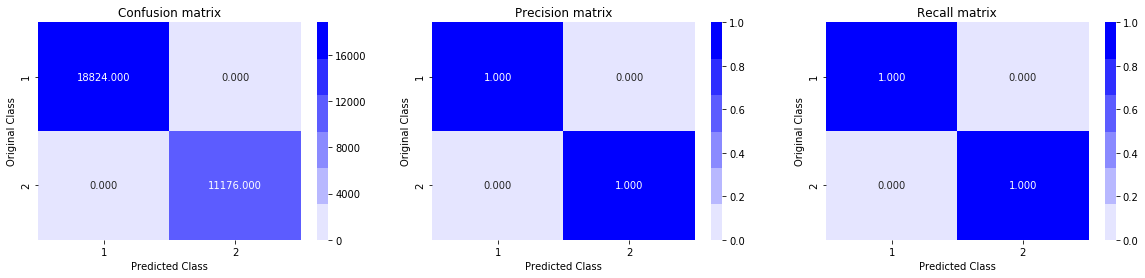

In [65]:
predict_y = best_model.predict(d_test)
predicted_y =np.array(predict_y>0.5,dtype=int)
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [2]:
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Model", "Train Log Loss", "Test Log Loss"]

pt.add_row(["Random Model", "-",0.887])
pt.add_row(["Logistic Regression", 0.529,0.539])
pt.add_row(["Linear SVM", 0.543,0.551])
pt.add_row(["GBDT (xgboost)", "-",2.7e-5])

print(pt)

+---------------------+----------------+---------------+
|        Model        | Train Log Loss | Test Log Loss |
+---------------------+----------------+---------------+
|     Random Model    |       -        |     0.887     |
| Logistic Regression |     0.529      |     0.539     |
|      Linear SVM     |     0.543      |     0.551     |
|    GBDT (xgboost)   |       -        |    2.7e-05    |
+---------------------+----------------+---------------+


1) We got a Train Log Loss of 0.529 and Test Log Loss of 0.539 which are almost equal and small, hence our Logistic Regression model might be underfitting. 

2) One more major concern with Logistic Regression Model was the Recall value for class 2 which is only 47%.

3) The above 2 points are also applied to Linear SVM model. And to see whether our model is underfitting or not, we move towards more complex models or add complexity to our model and if we get a better log loss then models are under-fitting.

4) Both of the above concerns are addressed by GBDT. We are getting a better Test Log Loss and getting 100% recall value.

### Steps Taken To Solve :



*  We created a few simple features based on frequency of words like number of common words in both the questions,ratio of comon words and total number of words, etc before preprocessing after looking at the data. 

*  And after doing univariate analysis, we found out that these features are useful since some of the data points can be very easily separated.

* Then we did preprocessed the data, which included removing stopwords, removing html tags, stemming, etc.

* Then we created some more features like ratio of common_word_count to min lenghth of word count,etc. 

*  We used fuzzy-wuzzy library to create some more new features like fuzz ratio, fuzz partial ratio, etc.

* And then we used TfIdf to vectorize our question pairs and later we stacked all these features into one for the input of our model.

* We chose Log-loss as our KPI because of two reasons. The first reason is that the cost of a mis-classification can be very high. and the second reason is we want probability of a pair of questions to be duplicates so that you can choose a threshold of our choice.

* And then we trained and tested our models in search of minimum log-loss.






